TESTED FEATURES: 
Index(['FullK', 'diffKD', 'OB', 'OS', 'vol', 's15', 's30', 's60', 'ToD',
       'perc30', 'perc60', 'RSI', 'Wpercent', 'acc'],
      dtype='object')
TESTING FOR: 
bull15
OCCURANCES IN RAW DATA FOR bull15: 
{'in': 23226, 'up': 2679}
ins -	 23226 
insMatch -	 2679 
non-ins -	 2679
PERCENT & WEIGHTS:
INS	-	50.0 %
Non-INS	-	50.0 %
OCCURANCES IN RAW DATA FOR bull15: 
{'in': 2679, 'up': 2679}
Epoch 1/2500


c:\Users\logan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4847 - loss: 0.1256 - val_accuracy: 0.5075 - val_loss: 0.2484
Epoch 2/2500
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4944 - loss: 0.1249 - val_accuracy: 0.5084 - val_loss: 0.2484
Epoch 3/2500
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5126 - loss: 0.1243 - val_accuracy: 0.5084 - val_loss: 0.2483
Epoch 4/2500
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4885 - loss: 0.1252 - val_accuracy: 0.5103 - val_loss: 0.2483
Epoch 5/2500
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4966 - loss: 0.1246 - val_accuracy: 0.5103 - val_loss: 0.2483
Epoch 6/2500
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4979 - loss: 0.1248 - val_accuracy: 0.5103 - val_loss: 0.2482
Epoch 7/2500
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4715 - loss: 0.1256 - val_accuracy: 0.5103 - val_loss: 0.2482
Epoch 8/2500
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4737 - loss: 0.1251 - val_accuracy:

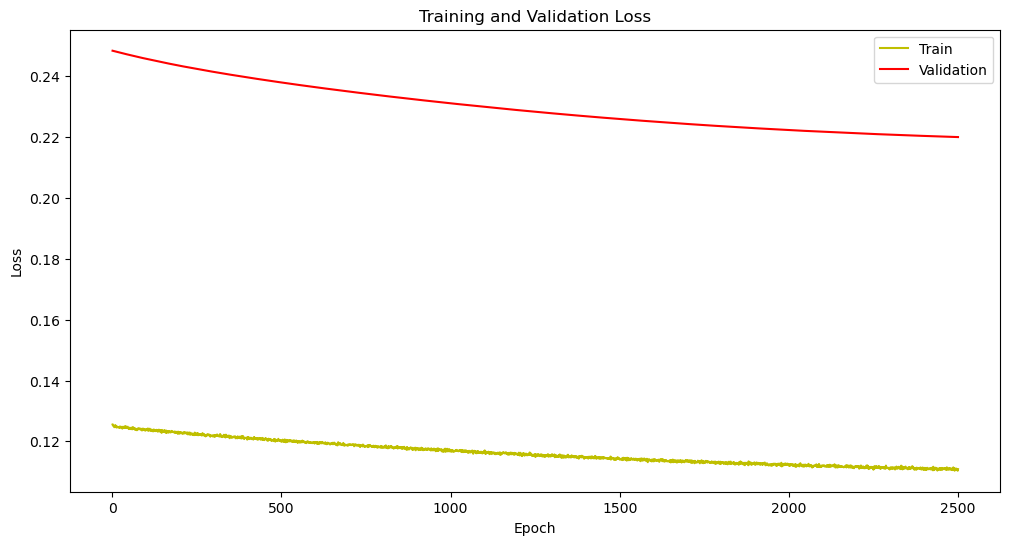

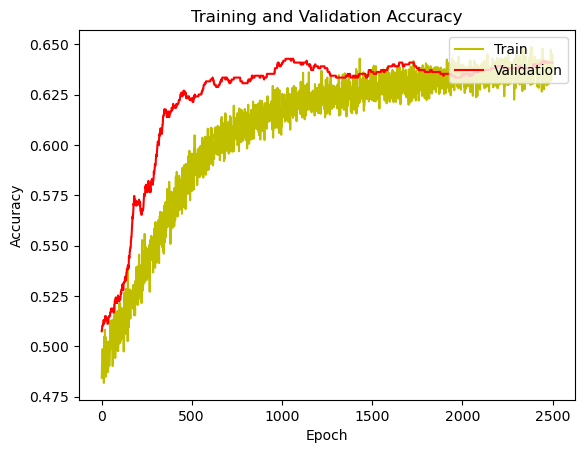

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

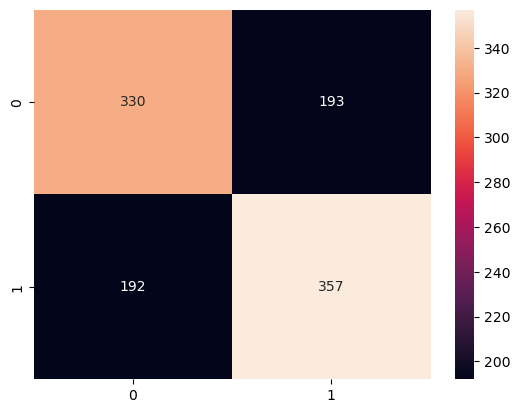

In [64]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal

tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('ES5m90dCLASS.csv')


#testing random feature drops
data = data.drop(columns='fullTime')
#data = data.drop(columns='FullK')
#data = data.drop(columns='diffKD')
#data = data.drop(columns='OB')
#data = data.drop(columns='OS')
#data = data.drop(columns='vol')
#data = data.drop(columns='s15')
#data = data.drop(columns='s30')
#data = data.drop(columns='s60')
#data = data.drop(columns='ToD')
#data = data.drop(columns='perc30')
#data = data.drop(columns='perc60')
data = data.drop(columns='percD') # causing problems
#data = data.drop(columns='RSI')
#data = data.drop(columns='Wpercent')
#data = data.drop(columns='acc')

#TEMP DROP PRE-DUAL-OUTPUT NN

#data = data.drop(columns='bull15')
data = data.drop(columns='bear15')

data = data.drop(columns='bull30')
data = data.drop(columns='bear30')

data = data.drop(columns='bull60')
data = data.drop(columns='bear60')

#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))

NinRows = data.drop(data[data['bull15'] == 'in'].index)

inRows = data.drop(data[data['bull15'] != 'in'].index)

inRowsMatch = inRows.loc[0:3001]

print('ins -\t',inRows.index.size,'\ninsMatch -\t',\
      inRowsMatch.index.size,'\nnon-ins -\t',NinRows.index.size)

optData = pd.concat([NinRows, inRowsMatch],axis=0)

percIn = inRowsMatch.size/optData.size
percNin = NinRows.size/optData.size
weight_for_0 = percIn
weight_for_1 = percNin
cw = {0: weight_for_1, 1: weight_for_0}

print("PERCENT & WEIGHTS:\nINS\t-\t",percIn*100," %\nNon-INS\t-\t",percNin*100," %",sep='')

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(optData.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))



#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = optData.iloc[:, :-1].values
y = optData.iloc[:, -1].values



#Encoding data
labelencoder = LabelBinarizer()
y = labelencoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------


opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(clipnorm=0.7)

def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, input_dim=14, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    rmse='root_mean_squared_error'

    model.compile(optimizer=opt1, loss='mse', metrics=['accuracy'])
    return model

#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 2500

model = build_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.25,\
                    shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                    class_weight=cw)

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

# Plot training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

#making a confusion matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')

# Save the model
#model.save('my_model.keras')
# Load the model
#loaded_model = tf.keras.models.load_model('my_model.keras')

In [65]:
''' Testing outputs for model (placed here so we don't have to retrain)'''
preds = model.predict(X_train)
print(preds[0:5])
print(preds[10000:10005])

model.summary()


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step
[[0.2936481 ]
 [0.4609212 ]
 [0.49698147]
 [0.67397404]
 [0.31861988]]
[]


Model: "sequential_63"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 512)            │         7,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,923 (1.53 MB)

 Trainable params: 401,921 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)